In [22]:
# Standard libraries
import os
import math
import time

# Data manipulation and analysis
import numpy as np
import pandas as pd

#Data Visualization
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta


# Machine Learning - Scikit-learn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, ParameterGrid, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  MinMaxScaler, StandardScaler


# Deep Learning - TensorFlow and Keras
import keras
import random
import tensorflow as tf
import keras.utils
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError


In [24]:
## Read in the data set kepping date as index
df=pd.read_csv('weighted_sum.csv')

# make 'date' column as index replacing default numerical index
df.index = df['date']

# drop the column labeled as date
df.drop(columns='date', inplace=True)


# Replace negative values with zero in 'weighted_sum'
df['weighted_sum'] = df['weighted_sum'].clip(lower=0)

# filter out the specified data range containing zero
df=df.drop(df.loc['2023-05-12':'2023-07-27'].index)

# filter out the first two months assuming machine unstability
df=df.drop(df.loc['2019-10-24':'2020-01-31'].index)

# replace 7 irregular data points with 8th highest value.
df[df['weighted_sum']>570]=570
print(df)

df_sorted=df.sort_values(by='weighted_sum', ascending=False)
df_sorted.head(20)

            weighted_sum
date                    
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
...                  ...
2023-12-02    114.049422
2023-12-03      0.000000
2023-12-04    226.893157
2023-12-05    390.659238
2023-12-06    425.322937

[1317 rows x 1 columns]


,weighted_sum
date,
2021-10-29,570.000000
2023-10-27,570.000000
2023-02-15,570.000000
2023-08-29,570.000000
2023-04-12,570.000000
2023-09-13,570.000000
2022-11-09,570.000000
2023-10-11,569.364018
2023-01-10,561.643202


In [28]:
df.index = range(len(df))
print(df)

      weighted_sum
0       239.210369
1        28.280318
2       199.366981
3       423.067131
4       409.692107
...            ...
1312    114.049422
1313      0.000000
1314    226.893157
1315    390.659238
1316    425.322937

[1317 rows x 1 columns]


Number of fold: 396.0

Initial train size: 921, Number of splits: 396


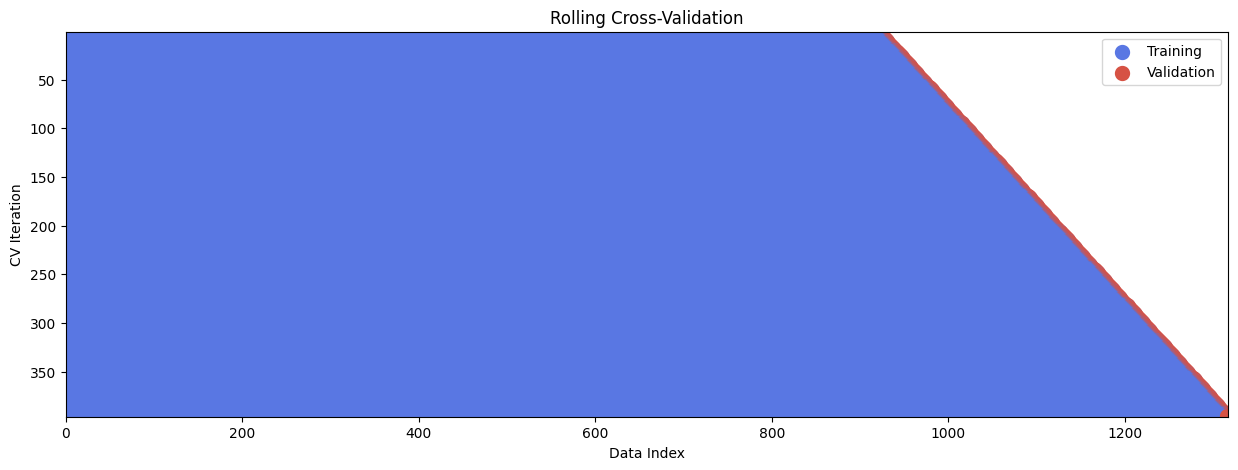

In [30]:
# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 80% training data
n_splits = len(df) - initial_train_size  # Remaining data for testing
test_size = 1  # Fixed test set size for each fold

n_folds= n_splits/test_size
print(f'Number of fold: {n_folds}')
print()

print(f"Initial train size: {initial_train_size}, Number of splits: {n_splits}")

# Visualization setup
fig, ax = plt.subplots(figsize=(15, 5))

# Iterate through the rolling cross-validation process
for i in range(0, n_splits, test_size):
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    #print(f"Train data from 0 to {train_end}, Test data from {train_end} to {test_end}")

    # Plot the training data
    l1 = ax.scatter(train_data.index, [i + 1] * len(train_data), c=[plt.cm.coolwarm(0.1)], 
                    marker='o', lw=5)
    
    # Plot the actual test data
    l2 = ax.scatter(test_data.index, [i + 1] * len(test_data), c=[plt.cm.coolwarm(0.9)], 
                    marker='o', lw=5)

# Set axis limits and labels
ax.set(ylim=[n_splits + 0.3, 0.7], xlim=[0, len(df)], title='Rolling Cross-Validation',  xlabel='Data Index', ylabel='CV Iteration')

# Add a legend to the plot
ax.legend([l1, l2], ['Training', 'Validation'])

plt.savefig('cross validation')
# Show the plot
plt.show()


In [7]:
# transformation of data in supervised learning
def ts_to_supervised(data, time_step=1):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(1, time_step + 1)]
    cols.append(df)
    data = pd.concat(cols, axis=1)
    data.fillna(0, inplace=True)
   
    # Rename columns to indicate time steps
    col_names = [f't-{i}' for i in range(1, time_step + 1)] + ['t']
    data.columns = col_names  # Assign column names
    return data.values[:, :-1], data.values[:, -1] # selects all columns except the last one, selects only the last column

# Transform to supervised learning
# train data
X_train, y_train= ts_to_supervised(train_data, time_step=7)

# test data
X_test, y_test= ts_to_supervised(test_data, time_step=7)

# Combine X and y into a single DataFrame 
supervised_df = pd.DataFrame(X_train, columns=[f't-{i}' for i in range(7, 0, -1)])
supervised_df['t'] = y_train

 # Print the first 20 rows
print(supervised_df.head(15))

           t-7         t-6         t-5         t-4         t-3         t-2  \
0     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1   239.210369    0.000000    0.000000    0.000000    0.000000    0.000000   
2    28.280318  239.210369    0.000000    0.000000    0.000000    0.000000   
3   199.366981   28.280318  239.210369    0.000000    0.000000    0.000000   
4   423.067131  199.366981   28.280318  239.210369    0.000000    0.000000   
5   409.692107  423.067131  199.366981   28.280318  239.210369    0.000000   
6   418.642235  409.692107  423.067131  199.366981   28.280318  239.210369   
7   437.622738  418.642235  409.692107  423.067131  199.366981   28.280318   
8   267.654169  437.622738  418.642235  409.692107  423.067131  199.366981   
9    25.190742  267.654169  437.622738  418.642235  409.692107  423.067131   
10  453.688387   25.190742  267.654169  437.622738  418.642235  409.692107   
11  452.785706  453.688387   25.190742  267.654169  437.622738  

In [8]:
# Function to transform data into a supervised learning format
def ts_to_supervised(data, time_step=14):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(1, time_step + 1)]
    cols.append(df)
    data = pd.concat(cols, axis=1)
    data.fillna(0, inplace=True)
   
    # Rename columns to indicate time steps
    col_names = [f't-{i}' for i in range(1, time_step + 1)] + ['t']
    data.columns = col_names  # Assign column names
    return data.values[:, :-1], data.values[:, -1]  # selects all columns except the last one, selects only the last column

# Set parameters for the model
num_layers = 3
num_neurons = 100
dropout_rate = 0.1
time_step = 14
num_epochs = 20 
learning_rate = 0.001 
batch_size = 32  

# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 70% training data
n_splits = (len(df) - initial_train_size)  # Remaining data for testing
test_size = 1  # Fixed test set size for each fold


In [46]:
# Initialize lists to hold RMSE for each fold across all splits
rmse_test_values_all = []
rmse_train_values_all = []

# List to hold all predictions
predictions_all = []

# Iterate through the rolling cross-validation process for all folds
for start in range(0, n_splits, 99):  # Adjust to cover all folds in batches of 99
    end = start + 99  # Each iteration covers 99 data points
    if end > n_splits:  # Ensure we don't exceed the number of splits
        break

    for i in range(start, end, test_size):
        # Define the end points for the current fold
        train_end = initial_train_size + i
        test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

        # Define the current training and test data for this split
        train_data = df.iloc[:train_end]
        test_data = df.iloc[train_end:test_end]

        # Transform to supervised learning
        X_train, y_train = ts_to_supervised(train_data, time_step=time_step)
        X_test, y_test = ts_to_supervised(test_data, time_step=time_step)

        # Reshape input to be [samples, time steps, features] for LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Build the LSTM model
        model = Sequential()
        model.add(keras.Input(shape=(time_step, 1)))

        for _ in range(num_layers - 1):
            model.add(LSTM(num_neurons, activation='relu', return_sequences=True))

        model.add(LSTM(num_neurons, dropout=dropout_rate, activation='relu'))
        model.add(Dense(1))

        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])

        t1 = time.time()
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
        t2 = time.time()
        print()
        print(t2 - t1)

        # Make predictions on the train and test data
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calculate RMSE
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        # Store RMSE for this fold
        rmse_test_values_all.append(test_rmse)
        rmse_train_values_all.append(train_rmse)

        # Store predictions for the current split
        predictions_all.append(y_pred_test)

        print(f'Fold {i // test_size + 1} Test RMSE: {test_rmse:.4f}')
        print(f'Fold {i // test_size + 1} Train RMSE: {train_rmse:.4f}')

# Compute and print the average RMSE across all folds for all 396 data points
average_rmse_test_all = np.mean(rmse_test_values_all)
average_rmse_train_all = np.mean(rmse_train_values_all)

print(f"Average Train RMSE across all folds: {average_rmse_train_all:.4f}")
print(f"Average Test RMSE across all folds: {average_rmse_test_all:.4f}")



16.79271173477173
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 1 Test RMSE: 408.2002
Fold 1 Train RMSE: 211.3748

16.913168907165527
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 2 Test RMSE: 310.8018
Fold 2 Train RMSE: 131.6072

17.094104051589966
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 3 Test RMSE: 114.3498
Fold 3 Train RMSE: 111.6738

16.32215404510498
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 4 Test RMSE: 272.5268
Fold 4 Train RMSE: 107.8316

17.61685085296631
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Fold 5 Test RMSE: 382.2861
Fold 5 Train RMSE: 157.3842

15.051255941390991
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 6 Test RMSE: 40.2668
Fold 6 Train RMSE: 104.7032

16.247443199157715
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [88]:
# Now, split the initial training data into 70% training and 30% validation
train_size = int(0.7 * len(df))
train_data= df[:train_size]
test_data = df[train_size:]

print(train_data.shape, test_data.shape)


# Find the index of the highest value in predictions_all_flat
highest_value_index = np.argmax(predictions_all_flat)

# Use the index to get the highest value and the corresponding prediction
highest_value = predictions_all_flat[highest_value_index]

# Print the result
print(f"Highest value: {highest_value} at index: {highest_value_index}")


(921, 1) (396, 1)
396
Highest value: [1145.6383] at index: 275


396


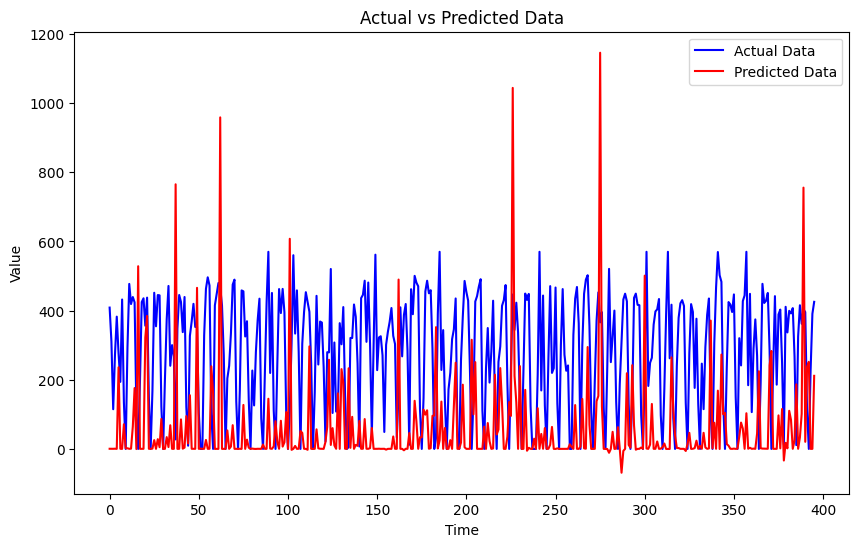

In [94]:
# Convert predictions_all (which is a list of arrays) into a flat array
predictions_all_flat = np.concatenate(predictions_all)
print(len(prediction_all_flat))

# Plot the actual values and the predictions
plt.figure(figsize=(10,6))

# Plot the actual test data
plt.plot(range(len(test_data)), test_data, label='Actual Data', color='blue')

# Plot the predictions (aligned with the same indices as test_data)
plt.plot(range(len(test_data)), prediction_all_flat, label='Predicted Data', color='red')

# Add title and labels
plt.title('Actual vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show the plot
plt.show()

###  prediction plot for 
num_layers = 2, 
num_neurons = 100, 
dropout_rate = 0.0, 
time_step = 30,
num_epochs = 20, 
learning_rate = 0.001, 
batch_size = 32,

(921, 1) (396, 1)
396
Highest value: 0.5361133217811584
Lowest value: -0.2306022047996521


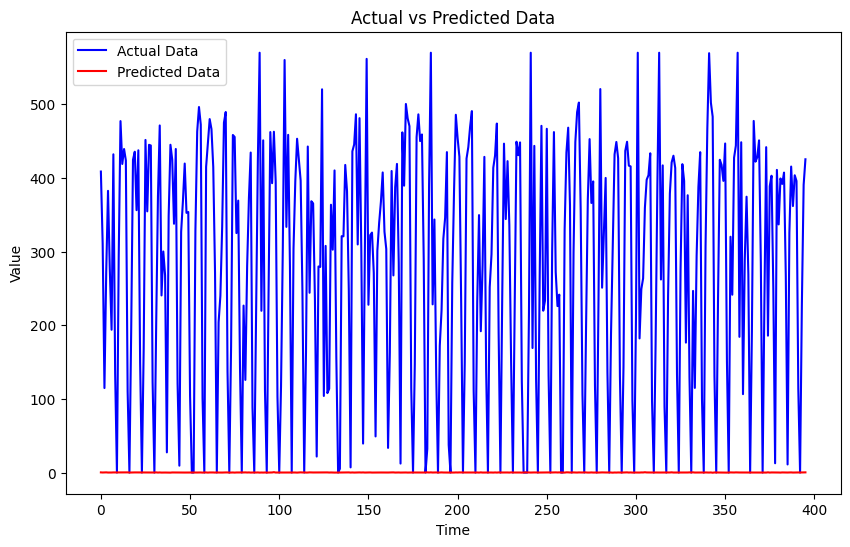

In [131]:
# Now, split the initial training data into 70% training and 30% validation
train_size = int(0.7 * len(df))
train_data= df[:train_size]
test_data = df[train_size:]

print(train_data.shape, test_data.shape)

# Convert predictions_all (which is a list of arrays) into a flat array
predictions_all_flat = np.concatenate(predictions_all)
print(len(predictions_all_flat))

# Find the highest and lowest values in predictions_all_flat
highest_value = np.max(predictions_all_flat)
lowest_value = np.min(predictions_all_flat)

# Print the results
print(f"Highest value: {highest_value}")
print(f"Lowest value: {lowest_value}")


# Plot the actual values and the predictions
plt.figure(figsize=(10,6))

# Plot the actual test data
plt.plot(range(len(test_data)), test_data, label='Actual Data', color='blue')

# Plot the predictions (aligned with the same indices as test_data)
plt.plot(range(len(test_data)), predictions_all_flat, label='Predicted Data', color='red')

# Add title and labels
plt.title('Actual vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [12]:
# List to hold RMSE for each fold
rmse_test_values = []
rmse_train_values = []

# Initialize lists to hold predictions
predictions_all1 = []

# Iterate through the rolling cross-validation process
for i in range(0, n_splits, test_size):
    if i >= 99:  # Break after processing the second 99 splits
        break
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Transform to supervised learning
    X_train, y_train = ts_to_supervised(train_data, time_step=time_step)
    X_test, y_test = ts_to_supervised(test_data, time_step=time_step)

    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()

    model.add(keras.Input(shape=(time_step, 1)))
    
    for _ in range(num_layers - 1):
        model.add(LSTM(num_neurons, activation='relu',return_sequences=True))
    
    model.add(LSTM(num_neurons,  dropout=dropout_rate, activation='relu'))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])
    
    t1=time.time()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
    t2=time.time()
    print()
    print(t2-t1)

    
    # Make predictions on the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    rmse_test_values.append(test_rmse)
    rmse_train_values.append(train_rmse)
   
    # Store predictions for the current split
    predictions_all1.append(y_pred_test)  # Flatten and append to list


    print(f'Fold {i // test_size + 1} Test RMSE: {test_rmse:.4f}')
    print(f'Fold {i // test_size + 1} Train RMSE: {train_rmse:.4f}')
    


15.729812860488892
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 1 Test RMSE: 389.8670
Fold 1 Train RMSE: 96.0740

16.053462028503418
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 2 Test RMSE: 310.9605
Fold 2 Train RMSE: 148.0402

15.202158212661743
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 3 Test RMSE: 123.3366
Fold 3 Train RMSE: 93.1863

15.621938943862915
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 4 Test RMSE: 234.4813
Fold 4 Train RMSE: 94.2338

14.927361249923706
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 5 Test RMSE: 382.3088
Fold 5 Train RMSE: 143.1550

15.086731910705566
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 6 Test RMSE: 275.1996
Fold 6 Train RMSE: 93.9442

15.404742956161499
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [14]:


# List to hold RMSE for each fol
rmse_test_values = []
rmse_train_values = []

# Initialize lists to hold predictions
predictions_all2 = []

# Iterate through the rolling cross-validation process
for i in range(99, n_splits, test_size):
    if i >= 198:  # Break after processing the second 99 splits
        break
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Transform to supervised learning
    X_train, y_train = ts_to_supervised(train_data, time_step=time_step)
    X_test, y_test = ts_to_supervised(test_data, time_step=time_step)

    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()

    model.add(keras.Input(shape=(time_step, 1)))
    
    for _ in range(num_layers - 1):
        model.add(LSTM(num_neurons, activation='relu',return_sequences=True))
    
    model.add(LSTM(num_neurons,  dropout=dropout_rate, activation='relu'))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])
    
    t1=time.time()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
    t2=time.time()
    print()
    print(t2-t1)

    
    # Make predictions on the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    rmse_test_values.append(test_rmse)
    rmse_train_values.append(train_rmse)

    # Store predictions for the current split
    predictions_all2.append(y_pred_test)  # Flatten and append to list

    print(f'Fold {i // test_size + 1} Test RMSE: {test_rmse:.4f}')
    print(f'Fold {i // test_size + 1} Train RMSE: {train_rmse:.4f}')
    
    


16.887243032455444
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 100 Test RMSE: 14.6466
Fold 100 Train RMSE: 118.5159

17.39983892440796
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 101 Test RMSE: 42.1025
Fold 101 Train RMSE: 178.6803

17.72232675552368
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 102 Test RMSE: 116.7516
Fold 102 Train RMSE: 153.5751

19.458191871643066
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 103 Test RMSE: 304.8138
Fold 103 Train RMSE: 162.9533

18.290926694869995
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Fold 104 Test RMSE: 559.7591
Fold 104 Train RMSE: 99.9298

19.21354389190674
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 105 Test RMSE: 333.4962
Fold 105 Train RMSE: 165.6931

17.86102819442749
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━

In [16]:

# List to hold RMSE for each fol
rmse_test_values = []
rmse_train_values = []
predictions_all3=[]



# Iterate through the rolling cross-validation process
for i in range(198, n_splits, test_size):
    if i >= 297:  # Break after processing the second 99 splits
        break
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Transform to supervised learning
    X_train, y_train = ts_to_supervised(train_data, time_step=time_step)
    X_test, y_test = ts_to_supervised(test_data, time_step=time_step)

    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()

    model.add(keras.Input(shape=(time_step, 1)))
    
    for _ in range(num_layers - 1):
        model.add(LSTM(num_neurons, activation='relu',return_sequences=True))
    
    model.add(LSTM(num_neurons,  dropout=dropout_rate, activation='relu'))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])
    
    t1=time.time()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
    t2=time.time()
    print()
    print(t2-t1)

    
    # Make predictions on the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Store predictions for the current split
    predictions_all3.append(y_pred_test)  # Flatten and append to list
    
    rmse_test_values.append(test_rmse)
    rmse_train_values.append(train_rmse)

    print(f'Fold {i // test_size + 1} Test RMSE: {test_rmse:.4f}')
    print(f'Fold {i // test_size + 1} Train RMSE: {train_rmse:.4f}')
    
    




18.84267282485962
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 199 Test RMSE: 381.5677
Fold 199 Train RMSE: 167.0204

17.970028162002563
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Fold 200 Test RMSE: 300.2685
Fold 200 Train RMSE: 109.0345

18.17663884162903
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 201 Test RMSE: 278.0991
Fold 201 Train RMSE: 119.9003

18.769626140594482
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 202 Test RMSE: 352.3277
Fold 202 Train RMSE: 162.2262

18.824373960494995
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 203 Test RMSE: 258.2425
Fold 203 Train RMSE: 206.6051

19.922088861465454
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 204 Test RMSE: 132.5756
Fold 204 Train RMSE: 103.7416

18.404942989349365
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

In [18]:

# List to hold RMSE for each fol
rmse_test_values = []
rmse_train_values = []
predictions_all4=[]

# Iterate through the rolling cross-validation process
for i in range(297, n_splits, test_size):
    if i >= 396:  # Break after processing the second 99 splits
        break
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Transform to supervised learning
    X_train, y_train = ts_to_supervised(train_data, time_step=time_step)
    X_test, y_test = ts_to_supervised(test_data, time_step=time_step)

    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()

    model.add(keras.Input(shape=(time_step, 1)))
    
    for _ in range(num_layers - 1):
        model.add(LSTM(num_neurons, activation='relu',return_sequences=True))
    
    model.add(LSTM(num_neurons,  dropout=dropout_rate, activation='relu'))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])
    
    t1=time.time()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
    t2=time.time()
    print()
    print(t2-t1)

    
    # Make predictions on the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    rmse_test_values.append(test_rmse)
    rmse_train_values.append(train_rmse)
    #Store predictions for the current split
    predictions_all4.append(y_pred_test)  # Flatten and append to list

    print(f'Fold {i // test_size + 1} Test RMSE: {test_rmse:.4f}')
    print(f'Fold {i // test_size + 1} Train RMSE: {train_rmse:.4f}')
    
# Compute and print the average RMSE across all folds
average_rmse_test = np.mean(rmse_test_values)
average_rmse_train = np.mean(rmse_train_values)

print(f"Average Train RMSE across all folds: {average_rmse_train:.4f}")
print(f"Average Test RMSE across all folds: {average_rmse_test:.4f}")


19.415032863616943
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 298 Test RMSE: 246.5737
Fold 298 Train RMSE: 97.1350

18.949792861938477
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 299 Test RMSE: 8.9684
Fold 299 Train RMSE: 120.4668

18.869436025619507
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold 300 Test RMSE: 0.2925
Fold 300 Train RMSE: 148.8984

18.876370906829834
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 301 Test RMSE: 102.0607
Fold 301 Train RMSE: 118.8931

18.786991834640503
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 302 Test RMSE: 552.2847
Fold 302 Train RMSE: 91.3861

18.805689811706543
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 303 Test RMSE: 181.8633
Fold 303 Train RMSE: 144.1317

18.77954125404358
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
1/1 ━

396
(921, 1) (396, 1)
Highest value: 1552.8226318359375
Lowest value: 0.0


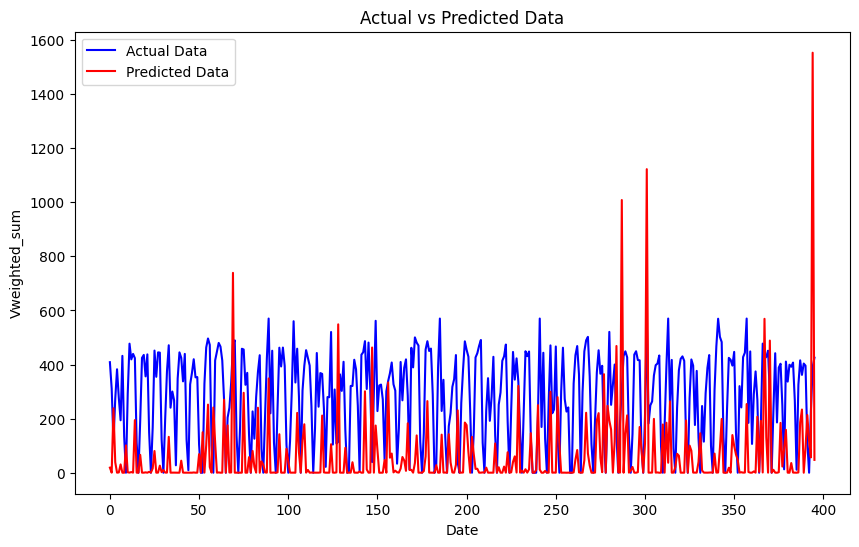

In [20]:
predictions_all=np.concatenate([predictions_all1, predictions_all2, predictions_all3, predictions_all4])

print(len(predictions_all))

predictions_all = predictions_all.reshape(-1)
predictions_all = predictions_all.clip(min=0)

# Now, split the initial training data into 70% training and 30% validation
train_size = int(0.7 * len(df))
train_data= df[:train_size]
test_data = df[train_size:]

print(train_data.shape, test_data.shape)


# Find the highest and lowest values in predictions_all_flat
highest_value = np.max(predictions_all)
lowest_value = np.min(predictions_all)

# Print the results
print(f"Highest value: {highest_value}")
print(f"Lowest value: {lowest_value}")


# Plot the actual values and the predictions
plt.figure(figsize=(10,6))

# Plot the actual test data
plt.plot(range(len(test_data)), test_data, label='Actual Data', color='blue')

# Plot the predictions (aligned with the same indices as test_data)
plt.plot(range(len(test_data)), predictions_all, label='Predicted Data', color='red')

# Add title and labels
plt.title('Actual vs Predicted Data')
plt.xlabel('Date')
plt.ylabel('Vweighted_sum')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [25]:

# Function to transform data into a supervised learning format
def ts_to_supervised(data, time_step=14):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(1, time_step + 1)]
    cols.append(df)
    data = pd.concat(cols, axis=1)
    data.fillna(0, inplace=True)
   
    # Rename columns to indicate time steps
    col_names = [f't-{i}' for i in range(1, time_step + 1)] + ['t']
    data.columns = col_names  # Assign column names
    return data.values[:, :-1], data.values[:, -1]  # selects all columns except the last one, selects only the last column

# Set parameters for the model
keras.utils.set_random_seed(8332)
num_layers = 3
num_neurons = 100
dropout_rate = 0.1
time_step = 14
num_epochs = 20 
learning_rate = 0.001 
batch_size = 32 

# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 70% training data
n_splits = len(df) - initial_train_size  # Remaining data for testing
test_size = 1  # Fixed test set size for each fold

# List to hold RMSE for each fold
rmse_test_values = []
rmse_train_values = []
predictions_values1=[]

# Iterate through the rolling cross-validation process
for i in range(0, 150, test_size):
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Transform to supervised learning
    X_train, y_train = ts_to_supervised(train_data, time_step=time_step)
    X_test, y_test = ts_to_supervised(test_data, time_step=time_step)

    

    # Build the LSTM model
    model = Sequential()

    model.add(keras.Input(shape=(time_step, 1)))
    
    for _ in range(num_layers - 1):
        model.add(LSTM(num_neurons, activation='relu',return_sequences=True))
    
    model.add(LSTM(num_neurons,  dropout=dropout_rate, activation='relu'))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])
    
    t1=time.time()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
    t2=time.time()
    print()
    print(t2-t1)

    
    # Make predictions on the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    rmse_test_values.append(test_rmse)
    rmse_train_values.append(train_rmse)
    predictions_values1.append(y_pred_test)

    print(f'Fold {i // test_size + 1} Test RMSE: {test_rmse:.4f}')
    print(f'Fold {i // test_size + 1} Train RMSE: {train_rmse:.4f}')
    

# Compute and print the average RMSE across all folds
average_rmse_test = np.mean(rmse_test_values)
average_rmse_train = np.mean(rmse_train_values)

print(f"Average Train RMSE across all folds: {average_rmse_train:.4f}")
print(f"Average Test RMSE across all folds: {average_rmse_test:.4f}")




17.486165761947632
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 1 Test RMSE: 383.3269
Fold 1 Train RMSE: 126.6798

17.040894269943237
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 2 Test RMSE: 310.8902
Fold 2 Train RMSE: 159.4760

18.34717106819153
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 3 Test RMSE: 114.6320
Fold 3 Train RMSE: 143.0346

15.096461772918701
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 4 Test RMSE: 272.9399
Fold 4 Train RMSE: 169.7299

15.418621301651001
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 5 Test RMSE: 288.5527
Fold 5 Train RMSE: 93.2875

15.858641862869263
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 6 Test RMSE: 276.1133
Fold 6 Train RMSE: 103.8919

16.017503023147583
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [53]:

# Function to transform data into a supervised learning format
def ts_to_supervised(data, time_step=14):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(1, time_step + 1)]
    cols.append(df)
    data = pd.concat(cols, axis=1)
    data.fillna(0, inplace=True)
   
    # Rename columns to indicate time steps
    col_names = [f't-{i}' for i in range(1, time_step + 1)] + ['t']
    data.columns = col_names  # Assign column names
    return data.values[:, :-1], data.values[:, -1]  # selects all columns except the last one, selects only the last column

# Set parameters for the model
keras.utils.set_random_seed(83)
num_layers = 3
num_neurons = 100
dropout_rate = 0.1
time_step = 14
num_epochs = 20 
learning_rate = 0.001 
batch_size = 32

# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 70% training data
n_splits = len(df) - initial_train_size  # Remaining data for testing
test_size = 1  # Fixed test set size for each fold

# List to hold RMSE for each fold
rmse_test_values = []
rmse_train_values = []
predictions_values2=[]


# Iterate through the rolling cross-validation process
for i in range(150, 396, test_size):
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Transform to supervised learning
    X_train, y_train = ts_to_supervised(train_data, time_step=time_step)
    X_test, y_test = ts_to_supervised(test_data, time_step=time_step)

    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()

    model.add(keras.Input(shape=(time_step, 1)))
    
    for _ in range(num_layers - 1):
        model.add(LSTM(num_neurons, activation='relu',return_sequences=True))
    
    model.add(LSTM(num_neurons,  dropout=dropout_rate, activation='relu'))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])
    
    t1=time.time()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
    t2=time.time()
    print(t2-t1)

    
    # Make predictions on the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    predictions_values2.append(y_pred_test)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    rmse_test_values.append(test_rmse)
    rmse_train_values.append(train_rmse)

    print(f'Fold {i // test_size + 1} Test RMSE: {test_rmse:.4f}')
    print(f'Fold {i // test_size + 1} Train RMSE: {train_rmse:.4f}')
    

# Compute and print the average RMSE across all folds
average_rmse_test = np.mean(rmse_test_values)
average_rmse_train = np.mean(rmse_train_values)

print(f"Average Train RMSE across all folds: {average_rmse_train:.4f}")
print(f"Average Test RMSE across all folds: {average_rmse_test:.4f}")



18.013654708862305
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Fold 151 Test RMSE: 227.6056
Fold 151 Train RMSE: 121.5643
18.7807719707489
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 152 Test RMSE: 319.9456
Fold 152 Train RMSE: 123.9395
19.588069200515747
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Fold 153 Test RMSE: 325.2372
Fold 153 Train RMSE: 133.2821
18.100746154785156
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 154 Test RMSE: 269.4622
Fold 154 Train RMSE: 138.2291
19.380867958068848
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 155 Test RMSE: 48.7459
Fold 155 Train RMSE: 205.6302
18.365430116653442
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 156 Test RMSE: 253.8798
Fold 156 Train RMSE: 102.1865
20.866219997406006
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1/1 ━━━━

396
(921, 1) (396, 1)
Highest value: 3045.2978515625
Lowest value: 0.0


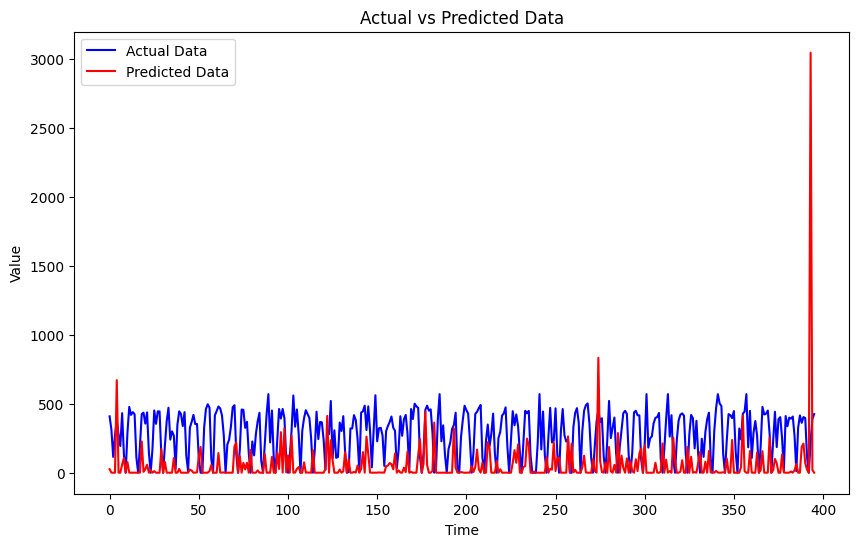

In [114]:
predictions_values=np.concatenate([predictions_values1,predictions_values2])

print(len(predictions_values))

predictions_values = predictions_values.clip(min=0)
predictions_values= predictions_values.reshape(-1)

# Now, split the initial training data into 70% training and 30% validation
train_size = int(0.7 * len(df))
train_data= df[:train_size]
test_data = df[train_size:]

print(train_data.shape, test_data.shape)


# Find the highest and lowest values in predictions_all_flat
highest_value = np.max(predictions_values)
lowest_value = np.min(predictions_values)

# Print the results
print(f"Highest value: {highest_value}")
print(f"Lowest value: {lowest_value}")


# Plot the actual values and the predictions
plt.figure(figsize=(10,6))

# Plot the actual test data
plt.plot(range(len(test_data)), test_data, label='Actual Data', color='blue')

# Plot the predictions (aligned with the same indices as test_data)
plt.plot(range(len(test_data)), predictions_values, label='Predicted Data', color='red')

# Add title and labels
plt.title('Actual vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [92]:


# Function to transform data into a supervised learning format
def ts_to_supervised(data, time_step=14):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(1, time_step + 1)]
    cols.append(df)
    data = pd.concat(cols, axis=1)
    data.fillna(0, inplace=True)
   
    # Rename columns to indicate time steps
    col_names = [f't-{i}' for i in range(1, time_step + 1)] + ['t']
    data.columns = col_names  # Assign column names
    return data.values[:, :-1], data.values[:, -1]  # selects all columns except the last one, selects only the last column

# Set parameters for the model
time_step = 14
num_layers = 3
num_neurons = 100
num_epochs = 20 
dropout_rate = 0.1
learning_rate = 0.001 
batch_size = 32  
predictions=[]

# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 80% training data
n_splits = len(df) - initial_train_size  # Remaining data for testing
test_size = 30  # Fixed test set size for each fold

# List to hold RMSE for each fold
rmse_test_values = []
rmse_train_values = []


# Iterate through the rolling cross-validation process
for i in range(0, n_splits, test_size):
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Transform to supervised learning
    X_train, y_train = ts_to_supervised(train_data, time_step=time_step)
    X_test, y_test = ts_to_supervised(test_data, time_step=time_step)


    # Build the LSTM model
    model = Sequential()

    model.add(keras.Input(shape=(time_step, 1)))
    
    for _ in range(num_layers - 1):
        model.add(LSTM(num_neurons, activation='relu',return_sequences=True))
    
    model.add(LSTM(num_neurons,  dropout=dropout_rate, activation='relu'))
    model.add(Dense(1))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])

    t1=time.time()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
    t2=time.time()

    print(t2-t1)
    
    # Make predictions on the train and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    rmse_test_values.append(test_rmse)
    rmse_train_values.append(train_rmse)
    predictions.append(y_pred_test)

    print(f'Fold {i // test_size + 1} Test RMSE: {test_rmse:.4f}')
    print(f'Fold {i // test_size + 1} Train RMSE: {train_rmse:.4f}')
    
    
# Compute and print the average RMSE across all folds
average_rmse_test = np.mean(rmse_test_values)
average_rmse_train = np.mean(rmse_train_values)

print(f"Average Train RMSE across all folds: {average_rmse_train:.4f}")
print(f"Average Test RMSE across all folds: {average_rmse_test:.4f}")



17.001121044158936
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 1 Test RMSE: 188.3867
Fold 1 Train RMSE: 180.2714
16.008665084838867
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Fold 2 Test RMSE: 162.7780
Fold 2 Train RMSE: 163.9146
18.657564163208008
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 3 Test RMSE: 208.7488
Fold 3 Train RMSE: 173.9805
17.513367176055908
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 4 Test RMSE: 149.0106
Fold 4 Train RMSE: 96.4119
170.37654209136963
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 5 Test RMSE: 152.9931
Fold 5 Train RMSE: 120.4236
17.021215200424194
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 6 Test RMSE: 128.3111
Fold 6 Train RMSE: 91.0604
17.888996839523315
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

(921, 1) (396, 1)
Highest value: 705.748291015625
Lowest value: 0.0


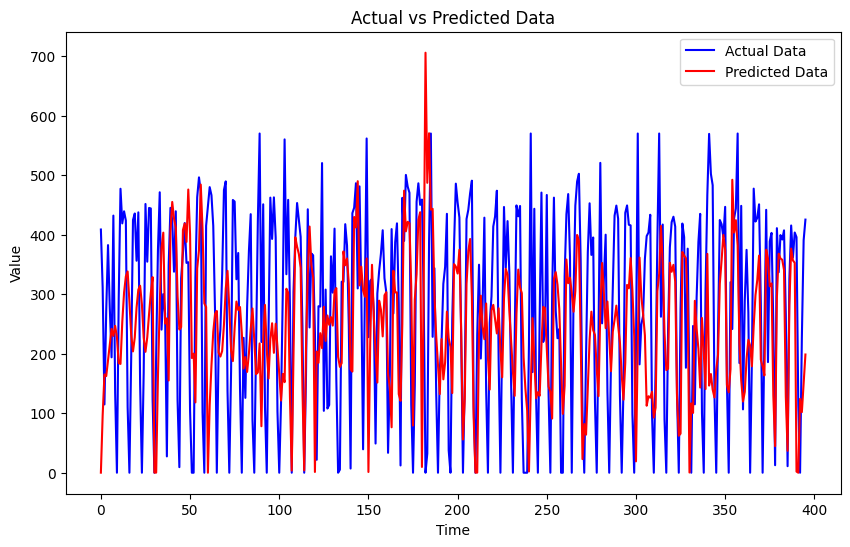

In [108]:
#predictions=np.concatenate(predictions)
train_size = int(0.7 * len(df))
train_data= df[:train_size]
test_data = df[train_size:]

print(train_data.shape, test_data.shape)


# Find the highest and lowest values in predictions_all_flat
highest_value = np.max(predictions)
lowest_value = np.min(predictions)

# Print the results
print(f"Highest value: {highest_value}")
print(f"Lowest value: {lowest_value}")


# Plot the actual values and the predictions
plt.figure(figsize=(10,6))

# Plot the actual test data
plt.plot(range(len(test_data)), test_data, label='Actual Data', color='blue')

# Plot the predictions (aligned with the same indices as test_data)
plt.plot(range(len(test_data)), predictions, label='Predicted Data', color='red')

# Add title and labels
plt.title('Actual vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Function to transform data into a supervised learning format
def ts_to_supervised(data, time_step=30):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(1, time_step + 1)]
    cols.append(df)
    data = pd.concat(cols, axis=1)
    data.fillna(0, inplace=True)
   
    # Rename columns to indicate time steps
    col_names = [f't-{i}' for i in range(1, time_step + 1)] + ['t']
    data.columns = col_names  # Assign column names
    return data.values[:, :-1], data.values[:, -1]  # selects all columns except the last one, selects only the last column

# Set parameters for the model
keras.utils.set_random_seed(832)
num_layers = 5
num_neurons = 100
dropout_rate = 0.1
time_step = 30
num_epochs = 20 
learning_rate = 0.001 
batch_size = 32  

# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 70% training data
n_splits = (len(df) - initial_train_size)  # Remaining data for testing
test_size = 1  # Fixed test set size for each fold


# Initialize lists to hold RMSE for each fold across all splits
rmse_test_values_all = []
rmse_train_values_all = []

# List to hold all predictions
predictions_all5 = []

# Iterate through the rolling cross-validation process for all folds
for start in range(0, n_splits, 99):  # Adjust to cover all folds in batches of 99
    end = start + 99  # Each iteration covers 99 data points
    if end > n_splits:  # Ensure we don't exceed the number of splits
        break

    for i in range(start, end, test_size):
        # Define the end points for the current fold
        train_end = initial_train_size + i
        test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

        # Define the current training and test data for this split
        train_data = df.iloc[:train_end]
        test_data = df.iloc[train_end:test_end]

        # Transform to supervised learning
        X_train, y_train = ts_to_supervised(train_data, time_step=time_step)
        X_test, y_test = ts_to_supervised(test_data, time_step=time_step)

        # Reshape input to be [samples, time steps, features] for LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Build the LSTM model
        model = Sequential()
        model.add(keras.Input(shape=(time_step, 1)))

        for _ in range(num_layers - 1):
            model.add(LSTM(num_neurons, activation='relu', return_sequences=True))

        model.add(LSTM(num_neurons, dropout=dropout_rate, activation='relu'))
        model.add(Dense(1))

        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['root_mean_squared_error'])

        t1 = time.time()
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=False)
        t2 = time.time()
        print()
        print(t2 - t1)

        # Make predictions on the train and test data
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calculate RMSE
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

        # Store RMSE for this fold
        rmse_test_values_all.append(test_rmse)
        rmse_train_values_all.append(train_rmse)

        # Store predictions for the current split
        predictions_all5.append(y_pred_test)

        print(f'Fold {i // test_size + 1} Test RMSE: {test_rmse:.4f}')
        print(f'Fold {i // test_size + 1} Train RMSE: {train_rmse:.4f}')

# Compute and print the average RMSE across all folds for all 396 data points
average_rmse_test_all = np.mean(rmse_test_values_all)
average_rmse_train_all = np.mean(rmse_train_values_all)

print(f"Average Train RMSE across all folds: {average_rmse_train_all:.4f}")
print(f"Average Test RMSE across all folds: {average_rmse_test_all:.4f}")


In [ ]:
plt.figure(figsize=(15,5))
    plt.plot(y_test, label='Actual')

    # Plot the predicted values
    plt.plot(model.predict(X_test), label='Predicted')

     # Add labels and title
    plt.xlabel('Time index')
    plt.ylabel('weighted_sum')
    plt.title('LSTM model prediction for TimeSeriesCV')
    plt.savefig('tscv predictions')
    plt.legend()

    # Show plot
    plt.show()
